In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [2]:
os.listdir('../input/ieee-fraud-detection')


['test_identity.csv',
 'sample_submission.csv',
 'train_identity.csv',
 'train_transaction.csv',
 'test_transaction.csv']

In [3]:
train_iden_df = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_trans_df = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")
test_trans_df = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
test_iden_df = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")

In [4]:
print('Dimensions of the Train Identity set:',train_iden_df.shape)
print('Dimensions of the Train transaction set:',train_trans_df.shape)
print('Dimensions of the Test transaction set:',test_trans_df.shape)
print('Dimensions of the Test Identity set:',test_iden_df.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train transaction set: (590540, 394)
Dimensions of the Test transaction set: (506691, 393)
Dimensions of the Test Identity set: (141907, 41)


In [5]:
train_iden_df.head()


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
train_trans_df.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())
# np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique()),axis=0)

0         False
1         False
2         False
3         False
4          True
          ...  
590535    False
590536    False
590537    False
590538    False
590539    False
Name: TransactionID, Length: 590540, dtype: bool

In [28]:
print(np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())))
print(np.sum(test_trans_df['TransactionID'].isin(test_iden_df['TransactionID'].unique())))


144233
141907


In [29]:
test_df = pd.merge(test_trans_df, test_iden_df, how = "left", on="TransactionID")
train_df = pd.merge(train_trans_df, train_iden_df, how="left", on="TransactionID")

In [30]:
print("Test Dataset shape: ", test_df.shape)
print("Train Dataset shape: ", train_df.shape)


Test Dataset shape:  (506691, 433)
Train Dataset shape:  (590540, 434)


In [31]:
train_df.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [32]:
test_df.head()


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# This Step is done to reduce memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [34]:
train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [35]:
for col_name in train_df.columns:
    if train_df[col_name].dtypes == 'object':
        unique_cat = len(train_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 categories
Featu

In [36]:
train_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.373047,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


In [37]:
cat_cols = [col for col in train_df.columns if train_df[col].dtypes == 'object']
train_df[cat_cols].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,...,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,...,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,...,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


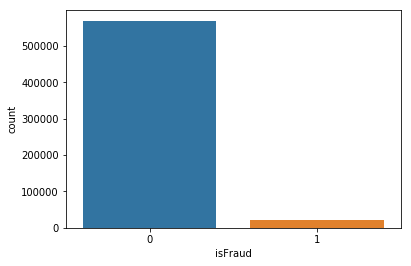

In [39]:
sns.countplot(train_df['isFraud'])

In [41]:
perc_fraud = len(train_df[train_df['isFraud']==1].index)*100/train_df.shape[0]
print("Percentage of Fradaulent records in dataset {:.2f}".format(perc_fraud) )

Percentage of Fradaulent records in dataset 3.50


In [42]:
# Check missing data - Many Columns have more than 50% NA/Null records
def missing_data(df) :
    count = df.isnull().sum()
    count1 = df.isnull().count()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent,count1], axis=1, keys = ['Count', 'Percent', 'actual count'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,0,0,0,0,0,8933,1565,1577,4259,...,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
Percent,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,...,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261,76.1557,79.9055
actual count,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,...,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540
dtypes,int32,int8,int32,float16,object,int16,float16,float16,object,float16,...,object,float16,object,object,object,object,object,object,object,object


In [43]:
null_percent = train_df.isnull().sum()/train_df.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 50].index)
cols_to_drop

array(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9',
       'D12', 'D13', 'D14', 'M5', 'M7', 'M8', 'M9', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147',
       'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
       'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
       'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
       'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
       'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
       'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
       'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
       'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
       'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
       'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
       'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
       '

In [44]:
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

In [45]:
train_df.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
train_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=220)

In [47]:
print(train_df.shape)
print(test_df.shape)

(590540, 220)
(506691, 219)


In [48]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [50]:
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [51]:
for f in train_X.columns:
    if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values) + list(test_df[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [ ]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = lr.predict_proba(test_df)[:,1]
submission.to_csv('ab_submission.csv')
submission.head()